In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pynoisy
import xarray as xr
import time, os
from tqdm.notebook import tqdm
import metric_utils

## Load eigenvectors
---

In [15]:
path = '../../scripts/clouds/eigenvectors/windang_deg24_wind_angle4.11_LOBPCG_maxiter30_rawgrf_changemeas.nc'

# maxiter = 60:
# path = '../../scripts/clouds/eigenvectors/windang_deg24_wind_angle1.96_LOBPCG_maxiter60_rawgrf_changemeas.nc'
info = xr.load_dataarray(path)
info

<xarray.DataArray (wind_angle: 40)>
array([0.        , 0.16110732, 0.32221463, 0.48332195, 0.64442926,
       0.80553658, 0.96664389, 1.12775121, 1.28885852, 1.44996584,
       1.61107316, 1.77218047, 1.93328779, 2.0943951 , 2.25550242,
       2.41660973, 2.57771705, 2.73882436, 2.89993168, 3.061039  ,
       3.22214631, 3.38325363, 3.54436094, 3.70546826, 3.86657557,
       4.02768289, 4.1887902 , 4.34989752, 4.51100484, 4.67211215,
       4.83321947, 4.99432678, 5.1554341 , 5.31654141, 5.47764873,
       5.63875604, 5.79986336, 5.96097068, 6.12207799, 6.28318531])
Dimensions without coordinates: wind_angle
Attributes:
    runname:          wind_angle_modes
    desc:             LOBPCG eigenvectors for different homogeneous wind angles
    date:             05-Nov-2020-12:53:31
    num_angles:       40
    min_angle:        0
    max_angle:        6.283185307179586
    lobpcg_iter:      30
    preconditioning:  True

In [3]:
eigenvectors = [xr.load_dataarray(path, group='mode{}'.format(i)) for i in range(info.num_angles)]

## Metric comparison
---

In [16]:
wind_angle_range = [info.min_angle, info.max_angle]
wind_angle_true = pynoisy.utils.uniform_sample(*wind_angle_range)
wind_angle_true = 1.2

hyperparams = {
    'nt': eigenvectors[0].nt.data,
    'nx': eigenvectors[0].nx.data,
    'ny': eigenvectors[0].ny.data,
    'wind_angle': wind_angle_true,
    'wind_magnitude': eigenvectors[0].wind_magnitude.data,
    'correlation_time': eigenvectors[0].correlation_time.data,
    'correlation_length': eigenvectors[0].correlation_length.data,
    'evolution_length': eigenvectors[0].evolution_length.data,
    'spatial_angle': eigenvectors[0].spatial_angle.data,
    'tensor_ratio': eigenvectors[0].tensor_ratio.data}
solver = pynoisy.forward.HGRFSolver.homogeneous(**hyperparams)
humidity = solver.run(num_frames=hyperparams['nt'], n_jobs=4, evolution_length=hyperparams['evolution_length'])

<IPython.core.display.Javascript object>


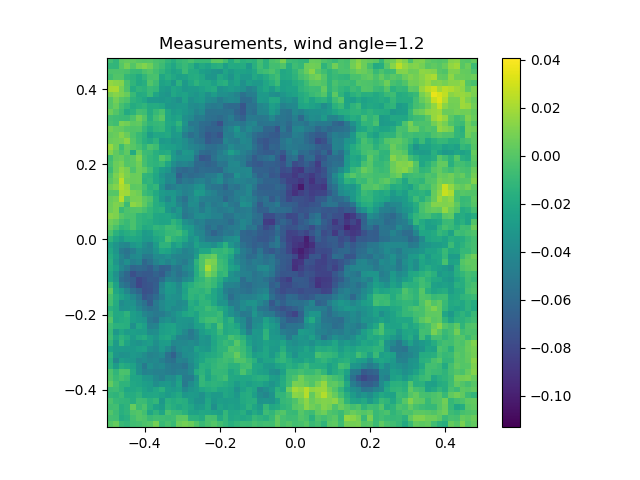

In [11]:
%matplotlib notebook
animation = humidity.noisy_methods.get_animation(cmap='viridis')
plt.title('Measurements, wind angle={:1.3}'.format(wind_angle_true))
animation.save('tmp.gif', writer='imagemagick')

In [17]:
"""
Compute likelihood metrics for eigenvector projection
"""
measurements = humidity
degrees = [1, 4, 8, 16, 24]    # number of eigenmodes
metrics = xr.merge([metric_utils.likelihood_metrics(measurements, eigenvectors, deg) for deg in degrees])

In [7]:
"""
Compute the full Rayleigh quotient for the full rank matrix
"""
coords = {info.dims[0]: info.data}
full_quotient = metric_utils.compute_full_quotient(humidity, hyperparams, coords)
full_quotient = xr.DataArray(full_quotient, dims=info.dims, coords=coords, name='full_quotient')
metrics = xr.merge([metrics, full_quotient])

Setting solver seed to: 15786

In [8]:
krylov_residual = metric_utils.compute_krylov_loss(measurements, hyperparams, coords, degrees)
metrics = xr.merge([metrics, krylov_residual])

Setting solver seed to: 29015


<IPython.core.display.Javascript object>


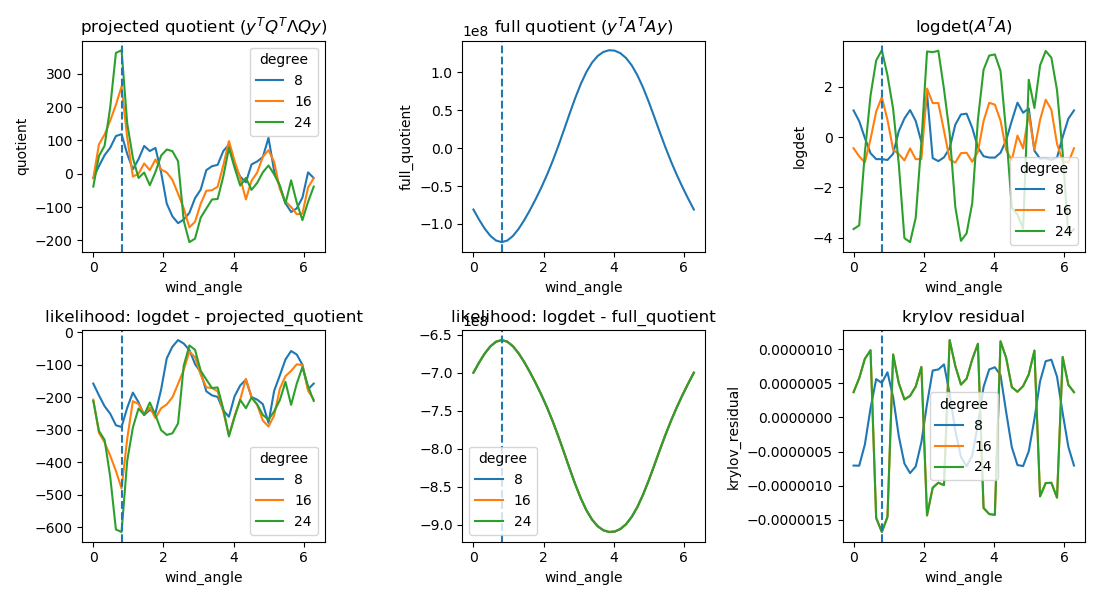

In [9]:
%matplotlib notebook

degrees = [8, 16, 24]
metrics_reduced = metrics.sel(degree=degrees)

fig, ax = plt.subplots(2, 3, figsize=(11,6))
(metrics_reduced.quotient - metrics_reduced.quotient.mean('wind_angle')).plot.line(ax=ax[0,0], hue='degree')
ax[0,0].set_title(r'projected quotient ($y^TQ^T \Lambda Q y$)')
ax[0,0].axvline(wind_angle_true, linestyle='--')

(metrics_reduced.full_quotient - metrics_reduced.full_quotient.mean('wind_angle')).plot.line(ax=ax[0,1])
ax[0,1].set_title(r'full quotient ($y^TA^T A y$)')
ax[0,1].axvline(wind_angle_true, linestyle='--')


(metrics_reduced.logdet - metrics_reduced.logdet.mean('wind_angle')).plot.line(ax=ax[0,2], hue='degree')
ax[0,2].set_title(r'$\log \det (A^TA)$')
ax[0,2].axvline(wind_angle_true, linestyle='--')

(metrics_reduced.logdet - metrics_reduced.quotient).plot.line(ax=ax[1,0], hue='degree')
ax[1,0].set_title('likelihood: logdet - projected_quotient')
ax[1,0].axvline(wind_angle_true, linestyle='--')


(metrics_reduced.logdet - metrics_reduced.full_quotient).plot.line(ax=ax[1,1], hue='degree')
ax[1,1].set_title('likelihood: logdet - full_quotient')
ax[1,1].axvline(wind_angle_true, linestyle='--')


(metrics_reduced.krylov_residual - metrics_reduced.krylov_residual.mean('wind_angle')).plot.line(ax=ax[1,2], hue='degree')
ax[1,2].set_title('krylov residual')
ax[1,2].axvline(wind_angle_true, linestyle='--')

plt.tight_layout()


## Full quotient confusion Matrix
---

In [101]:
hyperparams = {
    'nt': eigenvectors[0].nt.data,
    'nx': eigenvectors[0].nx.data,
    'ny': eigenvectors[0].ny.data,
    'wind_angle': 0.0,
    'wind_magnitude': eigenvectors[0].wind_magnitude.data,
    'correlation_time': eigenvectors[0].correlation_time.data,
    'correlation_length': eigenvectors[0].correlation_length.data,
    'evolution_length': eigenvectors[0].evolution_length.data,
    'spatial_angle': eigenvectors[0].spatial_angle.data,
    'tensor_ratio': eigenvectors[0].tensor_ratio.data}

confusion_matrix = []
for wind_angle in tqdm(info.data):
    hyperparams.update(wind_angle=wind_angle)
    solver = create_solver(**hyperparams)
    humidity = solver.run(num_frames=hyperparams['nt'], n_jobs=4, evolution_length=hyperparams['evolution_length'])
    full_quotient = compute_full_quotient(humidity, hyperparams, angles=info.data)
    confusion_matrix.append(xr.DataArray(
        full_quotient, dims='wind_angle', coords={'wind_angle': metrics.wind_angle}
    ).expand_dims(true_angle=[wind_angle]))
confusion_matrix = xr.concat(confusion_matrix, dim='true_angle')

Setting solver seed to: 20120


<IPython.core.display.Javascript object>


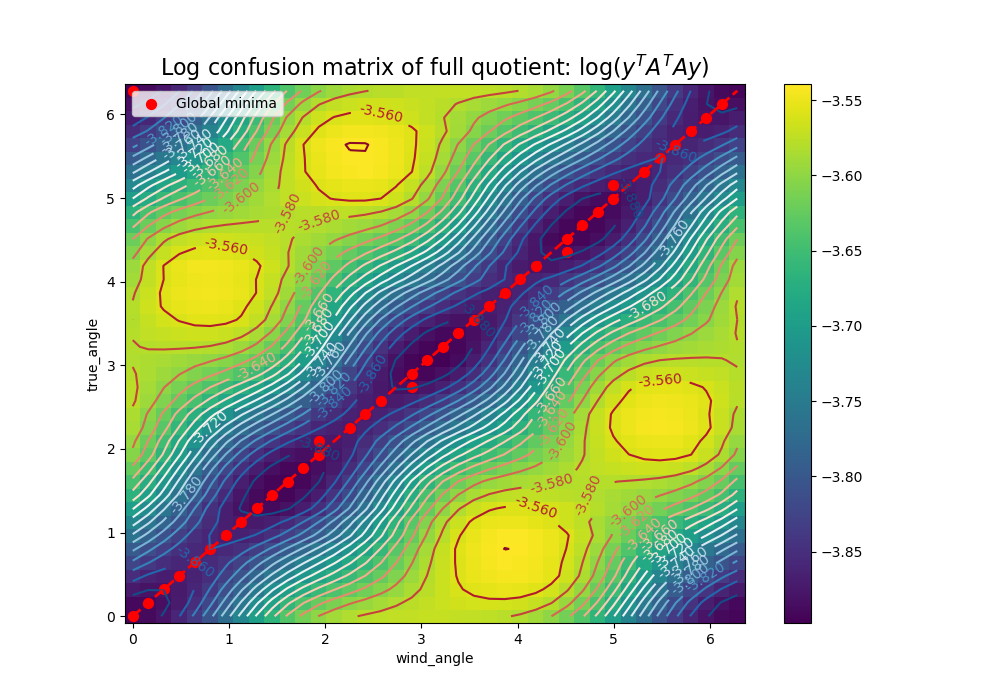

In [107]:
%matplotlib notebook

fig, ax = plt.subplots(1, 1, figsize=(10,7))
np.log(confusion_matrix / confusion_matrix.sum('wind_angle')).plot(ax=ax, add_labels=False)
cs = np.log(confusion_matrix / confusion_matrix.sum('wind_angle')).plot.contour(ax=ax, cmap='RdBu_r', levels=20)
ax.clabel(cs, inline=1, fontsize=10)
ax.set_title(r'Log confusion matrix of full quotient: $\log(y^T A^T A y)$', fontsize=16)
ax.plot(confusion_matrix.true_angle, confusion_matrix.true_angle, 'r--', linewidth=2)

# plot minimas
min_idx = confusion_matrix.argmin('wind_angle')
minima = confusion_matrix.wind_angle[min_idx]
ax.scatter(minima, confusion_matrix.true_angle, s=50, c='r', marker='o', label='Global minima')
plt.legend()